<a href="https://colab.research.google.com/github/chitra-psg/nlp_ticket_classification/blob/main/Automatic_Ticket_Classification_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install swifter

## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [2]:
import nltk
nltk.download('punkt')

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load(disable=['parser','ner'])
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import swifter
from sklearn.feature_extraction.text import TfidfTransformer
import re
import string

%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, classification_report, confusion_matrix

from sklearn import metrics


import warnings
warnings.filterwarnings('ignore')
from google.colab import drive


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [4]:
# Opening JSON file
drive.mount('/content/drive')

file_path = open('/content/drive/MyDrive/nlp/complaints-2021-05-14_08_16.json') # Write the path to your data file and load it

# returns JSON object as
# a dictionary
data = json.load(file_path)
df_sourcedata = pd.json_normalize(data)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data preparation

In [5]:
# Inspect the dataframe to understand the given data.

df_sourcedata.head(5)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [6]:
#Lets view the schema of the dataframe
df_sourcedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [7]:
#print the column names

# Print the column names
def print_column_names():
    i = 1
    for col in df_sourcedata.columns:
        print(str("{:02d}".format(i)) +" Column:\033[1m", col, '\033[0m')
        i += 1

print_column_names()

01 Column: _index 
02 Column: _type 
03 Column: _id 
04 Column: _score 
05 Column: _source.tags 
06 Column: _source.zip_code 
07 Column: _source.complaint_id 
08 Column: _source.issue 
09 Column: _source.date_received 
10 Column: _source.state 
11 Column: _source.consumer_disputed 
12 Column: _source.product 
13 Column: _source.company_response 
14 Column: _source.company 
15 Column: _source.submitted_via 
16 Column: _source.date_sent_to_company 
17 Column: _source.company_public_response 
18 Column: _source.sub_product 
19 Column: _source.timely 
20 Column: _source.complaint_what_happened 
21 Column: _source.sub_issue 
22 Column: _source.consumer_consent_provided 


In [8]:
#Lets removenthe prefix _ and also source.
#Assign new column names
new_columns = {}
for col in df_sourcedata.columns:
    new_columns[col] = re.sub("^_", "", col).replace("source.", "")

df_sourcedata.rename(columns = new_columns, inplace = True)

print_column_names()

01 Column: index 
02 Column: type 
03 Column: id 
04 Column: score 
05 Column: tags 
06 Column: zip_code 
07 Column: complaint_id 
08 Column: issue 
09 Column: date_received 
10 Column: state 
11 Column: consumer_disputed 
12 Column: product 
13 Column: company_response 
14 Column: company 
15 Column: submitted_via 
16 Column: date_sent_to_company 
17 Column: company_public_response 
18 Column: sub_product 
19 Column: timely 
20 Column: complaint_what_happened 
21 Column: sub_issue 
22 Column: consumer_consent_provided 


In [9]:
# Get the shape and size of the dataset
print('No of rows:', df_sourcedata.shape[0])
print('No of cols:', df_sourcedata.shape[1])

No of rows: 78313
No of cols: 22


In [10]:
# Check % of NULLs in each column
(df_sourcedata.isnull().sum()/ len(df_sourcedata)) * 100

index                         0.000000
type                          0.000000
id                            0.000000
score                         0.000000
tags                         86.081493
zip_code                      8.628197
complaint_id                  0.000000
issue                         0.000000
date_received                 0.000000
state                         2.542362
consumer_disputed             0.000000
product                       0.000000
company_response              0.000000
company                       0.000000
submitted_via                 0.000000
date_sent_to_company          0.000000
company_public_response      99.994892
sub_product                  13.498397
timely                        0.000000
complaint_what_happened       0.000000
sub_issue                    59.117899
consumer_consent_provided     1.287143
dtype: float64

In [11]:
#Assign nan in place of blanks in the complaints column
#df_sourcedata['complaint_what_happened'].unique()
len(df_sourcedata[df_sourcedata['complaint_what_happened'] == ''])

57241

In [12]:
#Remove all rows where complaints column is nan
df_data = df_sourcedata[df_sourcedata['complaint_what_happened'] != '']
print('Remaining Rows:', len(df_data))

Remaining Rows: 21072


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [13]:
# Write your function here to clean the text and remove all the unnecessary elements.
#def clean_data(text):
#    text = text.lower() # text to lowercase
#    text = re.sub(r'\s\{\$\S*', '',text) # Remove text within curly braces
#    text = re.sub(r'\n', '', text) # Remove line breaks
#    text = re.sub(r'\(\w*\)', '', text) #remove text within braces
#    text = re.sub(r'(\W\s)|(\W$)|(\W\d*)', ' ',text) # Remove punctuation
#    text = re.sub(r'x+((/xx)*/\d*\s*)|x*', '',text) #Remove date
#    text = re.sub(r'\d+\s', '', text) #Remove other numerical values
#    text = re.sub(r' +', ' ',text) #Remove unnecessary white spaces
#    return text

In [14]:

def clean_data(text):
    text = text.lower() # Convert the text to lowercase
    text = re.sub(r'\[.*?\]', '', text) # Remove text in square brackets using regular expression
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)# Remove punctuation using string.punctuation
    text = re.sub(r'\w*\d\w*', '', text)# Remove words containing numbers using regular expression
    text = ' '.join(text.split())# Remove extra spaces
    # Adding few more based on the data noticed
    #text = re.sub(r'x+((/xx)*/\d*\s*)|x*', '',text) #Remove date
    return text


In [15]:
# Apply data cleaning to the complaints_what_happened column
df_data['complaints'] = df_data['complaint_what_happened'].apply(clean_data)
df_data.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,complaints
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in and was told b...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card was reported on however fraudulent ...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,on while trying to book a xxxx xxxx ticket i c...
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for i deposit it in...


In [16]:
#Write your function to Lemmatize the texts
def lemmatization(text):
    tokens = word_tokenize(text)
    wordnet_lemmetizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmetizer.lemmatize(token) for token in tokens]
    lemmatized_str = " ".join(lemmatized)
    return lemmatized_str

In [17]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = pd.DataFrame({'complaints':df_data['complaints'], 'lemmatized':df_data['complaints'].apply(lemmatization)})

In [18]:
df_clean

,complaints,lemmatized
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...
...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...
78311,i have had flawless credit for yrs ive had cha...,i have had flawless credit for yr ive had chas...


In [19]:
#Write your function to extract the POS tags
def get_pos_tags(text):
    nn_words = []
    doc = nlp(text)
    for tok in doc:
        if(tok.tag_ == 'NN'):
            nn_words.append(tok.lemma_)
    nn_words_str = " ".join(nn_words)
    return nn_words_str

#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] =  df_clean.swifter.apply(lambda x: get_pos_tags(x['lemmatized']), axis=1)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [20]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints,lemmatized,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank service debt verificati...
2,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,xxxx agent anniversary date agent information ...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...
11,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...,xxxx ticket offer ticket reward card informati...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund chase bank account mone...
...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,xxxx credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,xxxx pay risk consumer chase bank app chase ye...
78311,i have had flawless credit for yrs ive had cha...,i have had flawless credit for yr ive had chas...,credit chase credit card chase freedom problem...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




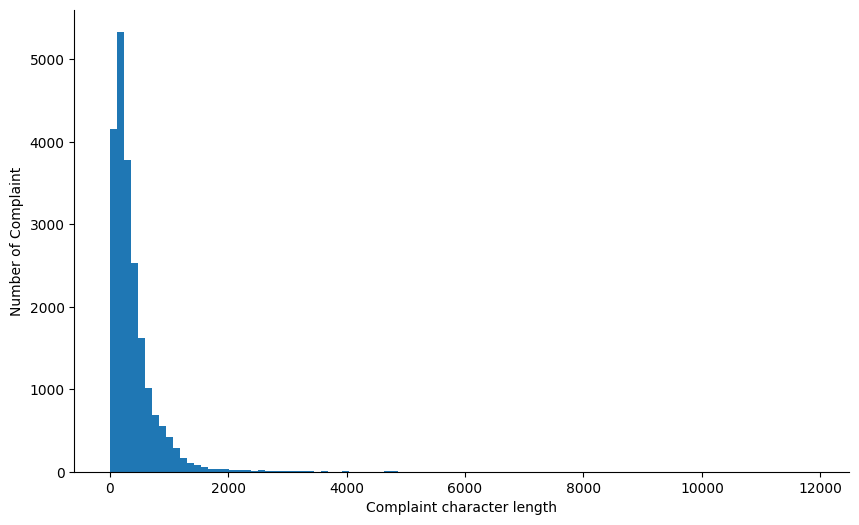

In [21]:
# Write your code here to visualise the data according to the 'Complaint' character length

plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 100)
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')
sns.despine();

#### Find the top 40 words by frequency among all the articles after processing the text.

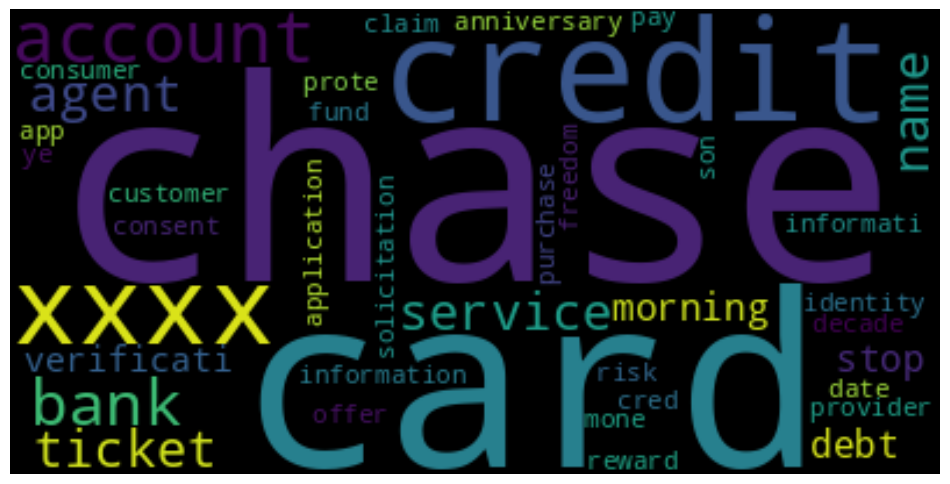

In [22]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
# Top 40 words frequency wise wordcloud
wordcloud = WordCloud(max_words=40, random_state=1, stopwords=set(STOPWORDS))
wordcloud.generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [23]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank service debt verificati...,morning name stop bank service debt verificati...
2,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,xxxx agent anniversary date agent information ...,xxxx agent anniversary date agent information ...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...
11,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...,xxxx ticket offer ticket reward card informati...,xxxx ticket offer ticket reward card informati...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,xxxx credit card provider claim purchase prote...,xxxx credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,xxxx pay risk consumer chase bank app chase ye...,xxxx pay risk consumer chase bank app chase ye...
78311,i have had flawless credit for yrs ive had cha...,i have had flawless credit for yr ive had chas...,credit chase credit card chase freedom problem...,credit chase credit card chase freedom problem...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [24]:

def get_top_n_ngrams(corpus, n=None, ngram_range=(1, 1)):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


In [25]:
unigram = get_top_n_ngrams(df_clean['Complaint_clean'].values.astype('U'), 10, ngram_range=(1,1))
df_unigram = pd.DataFrame(unigram, columns = ['unigram' , 'count'])
df_unigram

,unigram,count
0,chase,51401
1,account,46342
2,xxxx,33363
3,credit,32552
4,card,30105
5,payment,21157
6,bank,20744
7,time,16027
8,day,12961
9,money,11954


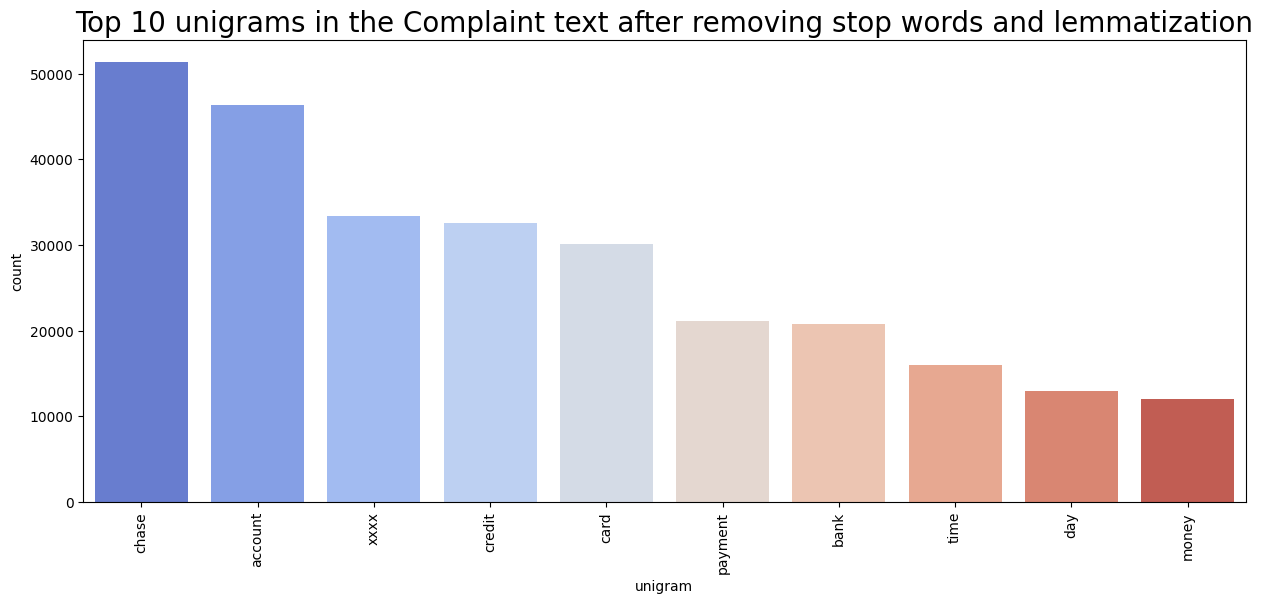

In [26]:
#Print the top 10 words in the unigram frequency
plt.figure(figsize=(15,6))
sns.barplot(x='unigram', y='count', data=df_unigram, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 10 unigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [27]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
bigram = get_top_n_ngrams(df_clean['Complaint_clean'].values.astype('U'), 10, ngram_range=(2,2))
df_bigram = pd.DataFrame(bigram, columns = ['bigram' , 'count'])
df_bigram

,bigram,count
0,credit card,12833
1,credit report,3843
2,account chase,3146
3,customer service,3057
4,chase account,2913
5,chase credit,2911
6,account account,2681
7,bank account,2517
8,xxxx xxxx,2390
9,chase bank,2070


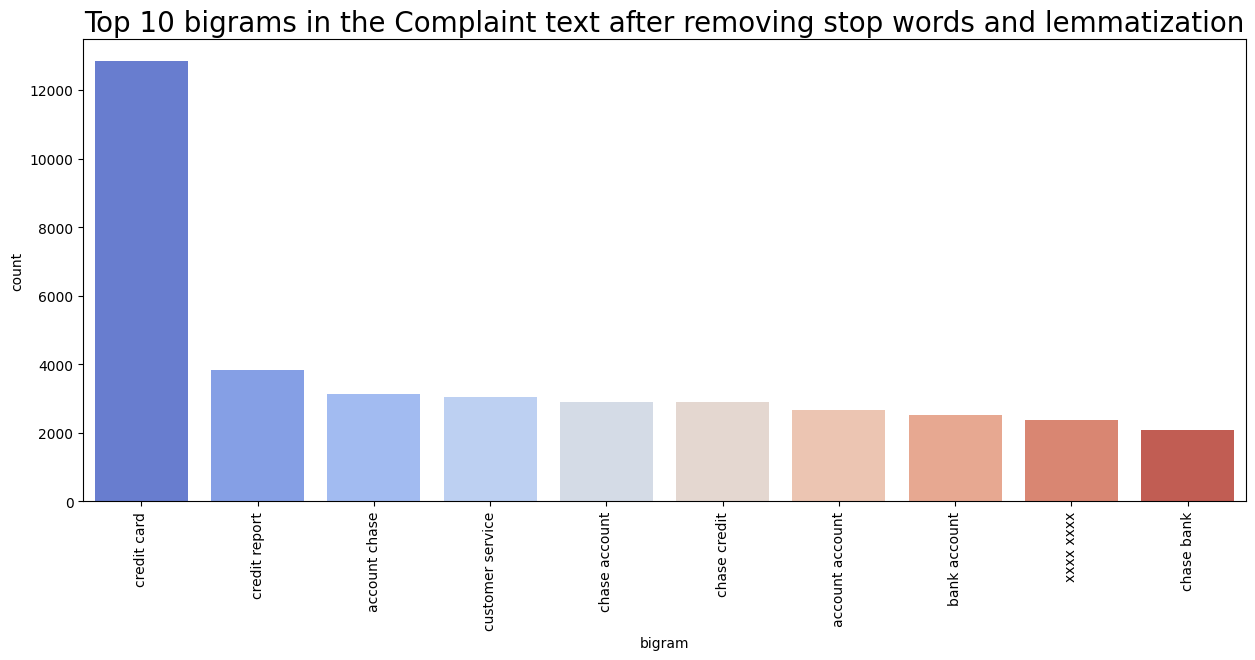

In [28]:
#Print the top 10 words in the bigram frequency
plt.figure(figsize=(15,6))
sns.barplot(x='bigram', y='count', data=df_bigram, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 10 bigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [29]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
trigram = get_top_n_ngrams(df_clean['Complaint_clean'].values.astype('U'), 10, ngram_range=(2,2))
df_trigram = pd.DataFrame(trigram, columns = ['trigram' , 'count'])
df_trigram

,trigram,count
0,credit card,12833
1,credit report,3843
2,account chase,3146
3,customer service,3057
4,chase account,2913
5,chase credit,2911
6,account account,2681
7,bank account,2517
8,xxxx xxxx,2390
9,chase bank,2070


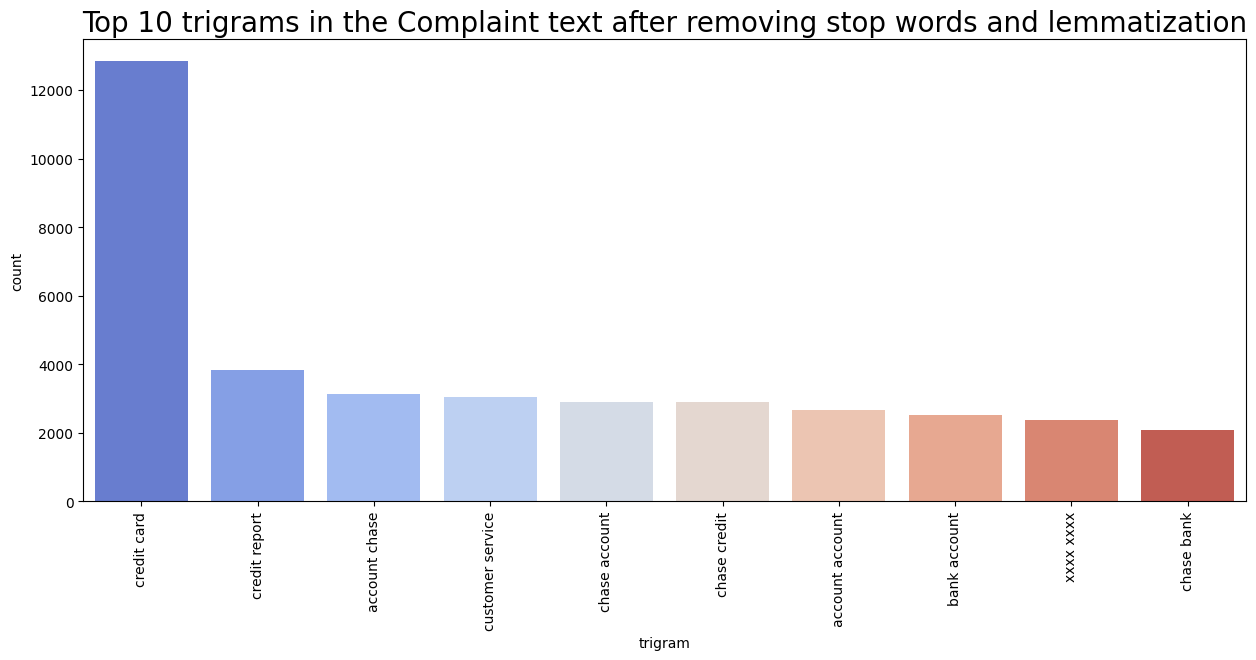

In [30]:
#Print the top 10 words in the trigram frequency
plt.figure(figsize=(15,6))
sns.barplot(x='trigram', y='count', data=df_trigram, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 10 trigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [31]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [32]:
#All masked texts has been removed
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank service debt verificati...,morning name stop bank service debt verificati...
2,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,xxxx agent anniversary date agent information ...,agent anniversary date agent information orde...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...
11,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...,xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,xxxx credit card provider claim purchase prote...,credit card provider claim purchase protectio...
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,xxxx pay risk consumer chase bank app chase ye...,pay risk consumer chase bank app chase year b...
78311,i have had flawless credit for yrs ive had cha...,i have had flawless credit for yr ive had chas...,credit chase credit card chase freedom problem...,credit chase credit card chase freedom problem...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [33]:
#Write your code here to initialise the TfidfVectorizer

tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words="english")


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [34]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

dtm = tfidf.fit_transform(df_clean.Complaint_clean)

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [35]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [36]:
# Load your nmf_model with the n_components i.e 5
num_topics = 5 # write the value you want to test out

# keep the random_state = 40
nmf_model = NMF(n_components=num_topics, random_state=40) # write your code here

In [37]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

6049

In [38]:
#Print the Top15 words for each of the topics
# Print the Top15 words for each of the topics
for index,topic in enumerate(nmf_model.components_):
    print(f'\033[1mTHE TOP 15 WORDS FOR TOPIC #{index + 1}', '\033[0m')
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')


THE TOP 15 WORDS FOR TOPIC #1 
['customer', 'transaction', 'number', 'business', 'checking', 'fee', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'bank', 'check', 'account']


THE TOP 15 WORDS FOR TOPIC #2 
['reason', 'service', 'offer', 'point', 'purchase', 'month', 'year', 'score', 'limit', 'fee', 'account', 'balance', 'chase', 'credit', 'card']


THE TOP 15 WORDS FOR TOPIC #3 
['day', 'statement', 'fee', 'property', 'balance', 'rate', 'year', 'time', 'modification', 'home', 'month', 'chase', 'mortgage', 'loan', 'payment']


THE TOP 15 WORDS FOR TOPIC #4 
['file', 'application', 'account', 'letter', 'theft', 'score', 'identity', 'debt', 'reporting', 'bureau', 'information', 'company', 'credit', 'report', 'inquiry']


THE TOP 15 WORDS FOR TOPIC #5 
['purchase', 'phone', 'time', 'company', 'information', 'service', 'email', 'letter', 'merchant', 'fraud', 'claim', 'dispute', 'transaction', 'chase', 'charge']




In [39]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_results = nmf_model.transform(dtm)
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)

array([0, 0, 1, ..., 4, 1, 2])

In [40]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_results.argmax(axis = 1) #write your code to assign topics to each rows.

In [41]:
df_clean.head()

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank service debt verificati...,morning name stop bank service debt verificati...,0
2,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,xxxx agent anniversary date agent information ...,agent anniversary date agent information orde...,0
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,1
11,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...,xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...,3
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0


In [42]:
# Print the first 5 Complaint for each of the Topics
df_clean5 = df_clean.groupby('Topic').head(5)
df_clean5.sort_values('Topic')

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank service debt verificati...,morning name stop bank service debt verificati...,0
2,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,xxxx agent anniversary date agent information ...,agent anniversary date agent information orde...,0
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restricted my ...,notice account debit card branch customer serv...,notice account debit card branch customer serv...,0
24,mishandling of this account by chase auto and ...,mishandling of this account by chase auto and ...,account chase auto xxxx,account chase auto,0
52,my roommate was stealing my chase debit card a...,my roommate wa stealing my chase debit card an...,roommate chase debit card driver license money...,roommate chase debit card driver license money...,1
50,i am a senior citizen that has been scammed by...,i am a senior citizen that ha been scammed by ...,citizen company time share company nothing ref...,citizen company time share company nothing ref...,1
40,xxxx xxxx a sofa love seat table and chairs an...,xxxx xxxx a sofa love seat table and chair and...,sofa love seat table chair debit card bank vis...,sofa love seat table chair debit card bank vis...,1
32,my chase amazon card was declined for a cateri...,my chase amazon card wa declined for a caterin...,chase catering order brother funeral amount ch...,chase catering order brother funeral amount ch...,1
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [43]:
# Create the dictionary of Topic names and Topics
Topic_names = {0:"Bank Account services",
               1:"Credit card or prepaid card",
               2:"Mortgage/Loan",
               3:"Theft/Dispute Reporting",
               4:"Others"}

# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)


In [44]:
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank service debt verificati...,morning name stop bank service debt verificati...,Bank Account services
2,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,xxxx agent anniversary date agent information ...,agent anniversary date agent information orde...,Bank Account services
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...,xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...,Theft/Dispute Reporting
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,Bank Account services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,Credit card or prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,xxxx credit card provider claim purchase prote...,credit card provider claim purchase protectio...,Others
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,xxxx pay risk consumer chase bank app chase ye...,pay risk consumer chase bank app chase year b...,Others
78311,i have had flawless credit for yrs ive had cha...,i have had flawless credit for yr ive had chas...,credit chase credit card chase freedom problem...,credit chase credit card chase freedom problem...,Credit card or prepaid card


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [45]:
# Create the dictionary again of Topic names and Topics

Topic_names = {"Bank Account services":0,
               "Credit card or prepaid card":1,
               "Mortgage/Loan":2,
               "Theft/Dispute Reporting":3,
               "Others":4,
               }

# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [46]:
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank service debt verificati...,morning name stop bank service debt verificati...,0
2,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,xxxx agent anniversary date agent information ...,agent anniversary date agent information orde...,0
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,1
11,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...,xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...,3
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,xxxx credit card provider claim purchase prote...,credit card provider claim purchase protectio...,4
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,xxxx pay risk consumer chase bank app chase ye...,pay risk consumer chase bank app chase year b...,4
78311,i have had flawless credit for yrs ive had cha...,i have had flawless credit for yr ive had chas...,credit chase credit card chase freedom problem...,credit chase credit card chase freedom problem...,1


In [47]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[["complaints","Topic"]]

In [48]:
training_data.shape

(21072, 2)

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [49]:
# Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaints)

# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [50]:

# Performing Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train:{y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test:{y_test.shape}")

Shape of X_train: (15804, 33599)
Shape of y_train:(15804,)
Shape of X_test: (5268, 33599)
Shape of y_test:(5268,)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [84]:

# Defining a function to evaluate the models

def evaluate_model(y_actual,y_pred):

    # Confusion matrix
    confusion = metrics.confusion_matrix(y_actual, y_pred)

    # Metrics calculation
    accuracy = metrics.accuracy_score(y_actual,y_pred)
    clf_report = metrics.classification_report(y_actual,y_pred)   # Sklearn classification report

    print("Accuracy   : " + str(accuracy))
    print("\nConfusion matrix:\n", confusion)
    print("\nClassificationReport:")
    print(clf_report)

    return accuracy

In [52]:
# Write your code here to build any 3 models and evaluate them using the required metrics
# Logistic Regression
lr = LogisticRegression().fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print(classification_report(y_true=y_test, y_pred=y_pred_lr))


              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1301
           1       0.91      0.90      0.90      1027
           2       0.93      0.95      0.94      1284
           3       0.93      0.84      0.88       530
           4       0.88      0.89      0.88      1126

    accuracy                           0.91      5268
   macro avg       0.91      0.90      0.91      5268
weighted avg       0.91      0.91      0.91      5268



In [53]:
# Calculate F1 Score using weighted average method
f1_lr = f1_score(y_test, y_pred_lr, average="weighted")
f1_lr

0.909450051910852

In [86]:
evaluate_model(y_test, y_pred_lr)

Accuracy   : 0.9096431283219438

Confusion matrix:
 [[1200   18   25    8   50]
 [  19  923   17   15   53]
 [  15   15 1222    5   27]
 [  16   37   19  445   13]
 [  64   21   33    6 1002]]

ClassificationReport:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1301
           1       0.91      0.90      0.90      1027
           2       0.93      0.95      0.94      1284
           3       0.93      0.84      0.88       530
           4       0.88      0.89      0.88      1126

    accuracy                           0.91      5268
   macro avg       0.91      0.90      0.91      5268
weighted avg       0.91      0.91      0.91      5268



0.9096431283219438

In [56]:
# Decision tree classifier
dt = DecisionTreeClassifier().fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print(classification_report(y_pred=y_pred_dt, y_true=y_test))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78      1301
           1       0.76      0.77      0.76      1027
           2       0.85      0.82      0.84      1284
           3       0.73      0.68      0.71       530
           4       0.68      0.68      0.68      1126

    accuracy                           0.76      5268
   macro avg       0.76      0.75      0.75      5268
weighted avg       0.76      0.76      0.76      5268



In [57]:
# Calculate F1 Score using weighted average method
f1_dt = f1_score(y_test, y_pred_dt, average="weighted")
f1_dt

0.7622811182277436

In [87]:
evaluate_model(y_test, y_pred_dt)

Accuracy   : 0.762338648443432

Confusion matrix:
 [[1036   48   55   26  136]
 [  37  792   34   47  117]
 [  83   39 1059   34   69]
 [  38   54   41  363   34]
 [ 163  111   60   26  766]]

ClassificationReport:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      1301
           1       0.76      0.77      0.76      1027
           2       0.85      0.82      0.84      1284
           3       0.73      0.68      0.71       530
           4       0.68      0.68      0.68      1126

    accuracy                           0.76      5268
   macro avg       0.76      0.75      0.75      5268
weighted avg       0.76      0.76      0.76      5268



0.762338648443432

In [59]:
rfc = RandomForestClassifier(max_depth=10)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)

print(classification_report(y_pred=y_pred_rfc, y_true=y_test))

              precision    recall  f1-score   support

           0       0.63      0.93      0.75      1301
           1       0.78      0.56      0.65      1027
           2       0.73      0.93      0.82      1284
           3       1.00      0.17      0.29       530
           4       0.76      0.60      0.67      1126

    accuracy                           0.71      5268
   macro avg       0.78      0.64      0.64      5268
weighted avg       0.75      0.71      0.69      5268



In [60]:
# Calculate F1 Score using weighted average method
f1_rfc = f1_score(y_test, y_pred_rfc, average="weighted")
f1_rfc

0.6858283218983976

In [88]:
evaluate_model(y_test, y_pred_rfc)

Accuracy   : 0.7120349278663629

Confusion matrix:
 [[1213   15   58    0   15]
 [ 190  572  137    0  128]
 [  65    7 1196    0   16]
 [ 117  108  161   90   54]
 [ 332   28   86    0  680]]

ClassificationReport:
              precision    recall  f1-score   support

           0       0.63      0.93      0.75      1301
           1       0.78      0.56      0.65      1027
           2       0.73      0.93      0.82      1284
           3       1.00      0.17      0.29       530
           4       0.76      0.60      0.67      1126

    accuracy                           0.71      5268
   macro avg       0.78      0.64      0.64      5268
weighted avg       0.75      0.71      0.69      5268



0.7120349278663629

In [54]:

from sklearn.model_selection import train_test_split, GridSearchCV

# Define a grid of hyperparameters to search
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 1000, 10000]
}

# Create a Logistic Regression classifier
lr_classifier = LogisticRegression(random_state=42)

# Perform grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(estimator=lr_classifier, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Create a new Logistic Regression classifier with the best parameters
best_lr_classifier = LogisticRegression(random_state=42, **best_params)

# Fit the classifier on the training data
best_lr_classifier.fit(X_train, y_train)

# Make predictions on the test data using the best parameters
y_pred_lr_best = best_lr_classifier.predict(X_test)

# Evaluate the model using classification report
print("Classification Report:")
print(classification_report(y_true=y_test, y_pred=y_pred_lr_best))

Best Parameters: {'C': 100, 'max_iter': 100, 'penalty': 'l2'}
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1301
           1       0.91      0.92      0.91      1027
           2       0.93      0.95      0.94      1284
           3       0.93      0.87      0.90       530
           4       0.88      0.89      0.88      1126

    accuracy                           0.91      5268
   macro avg       0.91      0.91      0.91      5268
weighted avg       0.91      0.91      0.91      5268



In [55]:
# Calculate F1 Score using weighted average method
f1_best_lr = f1_score(y_test, y_pred_lr_best, average="weighted")
f1_best_lr

0.9125751140655105

In [89]:
evaluate_model(y_test, y_pred_lr_best)

Accuracy   : 0.9126803340926348

Confusion matrix:
 [[1188   28   30    8   47]
 [  15  940   11   14   47]
 [  20    8 1222    6   28]
 [  12   29   18  460   11]
 [  71   23   27    7  998]]

ClassificationReport:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1301
           1       0.91      0.92      0.91      1027
           2       0.93      0.95      0.94      1284
           3       0.93      0.87      0.90       530
           4       0.88      0.89      0.88      1126

    accuracy                           0.91      5268
   macro avg       0.91      0.91      0.91      5268
weighted avg       0.91      0.91      0.91      5268



0.9126803340926348

### Model Inference

In [90]:
#Create the dictionary of Topic names and Topics

Topic_names =   { 0 : "Bank account services",
                  1 : "Credit Card/Prepaid Card",
                  2 : "Mortgages/loans",
                  3 : "Theft/Dispute reporting",
                  4 : "Others" }


#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [70]:
print(Topic_names)

{0: 'Bank account services', 1: 'Credit Card/Prepaid Card', 2: 'Mortgages/loans', 3: 'Theft/Dispute reporting', 4: 'Others'}


In [96]:
def predict_complaint_type(test_complaint):
  # clean the raw text
  test_complaint = clean_data(test_complaint)
  test_complaint = lemmatization(test_complaint)
  test_complaint = get_pos_tags(test_complaint)
  print(test_complaint)

  # vectorize and tf-idf tranform
  test = count_vect.transform([test_complaint])
  test_tfidf = tfidf_transformer.transform(test)

  # predict
  prediction=best_lr_classifier.predict(test_tfidf)

  return Topic_names[prediction[0]]

In [98]:
test_complaint_1 = 'I understand that resolving cases of fraud may take some time, but I kindly request your prompt attention \
to this matter to minimize any further inconvenience and financial impact on my part. \
I am ready and willing to cooperate fully with your investigative efforts.'
predict_complaint_type(test_complaint_1)

case fraud time attention matter inconvenience impact part effort


'Others'

In [99]:
test_complaint_2 = 'I tried to make a transaction at a supermarket retail store, using my chase \
#debit/atm card, but the transaction was declined. I am still able to withdraw money out of an \
#ATM machine using the same debit card. Please resolve this issue.'
predict_complaint_type(test_complaint_2)

transaction supermarket store debitatm card transaction money machine debit card issue


'Credit Card/Prepaid Card'